In [1]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

import pandas as pd
from pandas.plotting import register_matplotlib_converters

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import geopandas as gpd
from geopandas.tools import geocode

import colorcet as cc
import pycountry

import folium
import math
import numpy as np
from scipy import stats
register_matplotlib_converters()


# this line tells jupyter notebook to put the plots in the notebook rather than saving them to file.
%matplotlib inline

## Loading data

In [2]:
population_df = pd.read_csv('./data/population.csv', thousands = ',')
average_rainfall_df = pd.read_csv('./data/average_rainfall.csv', thousands = ',')
average_temperature_df = pd.read_csv('./data/average_temperature.csv', thousands = ',')
gdp_df = pd.read_csv('./data/gdp.csv')
median_age_df = pd.read_csv('./data/median_age.csv', thousands = ',')
covid_19 = pd.read_csv('./data/owid-covid-data.csv', thousands = ',')

# Data preprocessing

## Covid 19 Dataset
### Filtering South East Asia countries

In [3]:
sea_countries = ['Brunei', 'Cambodia', 'Indonesia', 'Malaysia', 'Myanmar', 'Laos',
                           'Philippines', 'Singapore', 'Thailand', 'Timor', 'Vietnam']
covid_19= covid_19[covid_19['location'].isin(sea_countries)]
covid_19

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
20776,BRN,Asia,Brunei,2020-03-09,1.0,1.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20777,BRN,Asia,Brunei,2020-03-10,1.0,0.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20778,BRN,Asia,Brunei,2020-03-11,11.0,10.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20779,BRN,Asia,Brunei,2020-03-12,11.0,0.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
20780,BRN,Asia,Brunei,2020-03-13,37.0,26.0,NaN,NaN,NaN,NaN,...,2.0,30.9,NaN,2.7,75.86,0.838,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148452,VNM,Asia,Vietnam,2021-12-28,1680985.0,14440.0,15600.714,31632.0,214.0,227.286,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
148453,VNM,Asia,Vietnam,2021-12-29,1694874.0,13889.0,15219.857,31877.0,245.0,232.286,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
148454,VNM,Asia,Vietnam,2021-12-30,1714742.0,19868.0,15718.571,32168.0,291.0,233.857,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN
148455,VNM,Asia,Vietnam,2021-12-31,1731257.0,16515.0,15769.714,32394.0,226.0,232.571,...,1.0,45.9,85.847,2.6,75.40,0.704,NaN,NaN,NaN,NaN


### Select necessary columns

In [4]:
covid_19.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [5]:
selected_columns = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 
                    'new_deaths', 'new_tests', 'total_tests',
                    'new_vaccinations', 'total_vaccinations','stringency_index']
covid_19 = covid_19[selected_columns].fillna(0)

In [6]:
covid_19.replace({'Timor': 'Timor Leste'}, inplace=True)

In [7]:
covid_19[covid_19['location']=='Timor Leste']

,location,date,total_cases,new_cases,total_deaths,new_deaths,new_tests,total_tests,new_vaccinations,total_vaccinations,stringency_index
135847,Timor Leste,2020-03-22,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.89
135848,Timor Leste,2020-03-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
135849,Timor Leste,2020-03-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
135850,Timor Leste,2020-03-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
135851,Timor Leste,2020-03-26,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
...,...,...,...,...,...,...,...,...,...,...,...
136493,Timor Leste,2021-12-28,19833.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
136494,Timor Leste,2021-12-29,19833.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
136495,Timor Leste,2021-12-30,19833.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00
136496,Timor Leste,2021-12-31,19837.0,4.0,122.0,0.0,0.0,0.0,0.0,0.0,0.00


### Rename to formal format

In [8]:
covid_19 = covid_19.rename(columns={"location": "Country name", "date": "Date", "total_cases": "Total cases",
                        "new_cases": "New cases", "total_deaths": "Total deaths", "new_deaths": "New deaths",
                         'total_tests': "Total tests", 'new_tests': "New tests", 'total_vaccinations': "Total vaccineinations",
                        'new_vaccinations': "New vaccineinations", 'stringency_index': "Stringency index"})

In [9]:
covid_19

,Country name,Date,Total cases,New cases,Total deaths,New deaths,New tests,Total tests,New vaccineinations,Total vaccineinations,Stringency index
20776,Brunei,2020-03-09,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.44
20777,Brunei,2020-03-10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.44
20778,Brunei,2020-03-11,11.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
20779,Brunei,2020-03-12,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.56
20780,Brunei,2020-03-13,37.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00
...,...,...,...,...,...,...,...,...,...,...,...
148452,Vietnam,2021-12-28,1680985.0,14440.0,31632.0,214.0,0.0,0.0,0.0,148198862.0,0.00
148453,Vietnam,2021-12-29,1694874.0,13889.0,31877.0,245.0,0.0,35752995.0,0.0,0.0,0.00
148454,Vietnam,2021-12-30,1714742.0,19868.0,32168.0,291.0,112223.0,35865218.0,0.0,0.0,0.00
148455,Vietnam,2021-12-31,1731257.0,16515.0,32394.0,226.0,87782.0,35953000.0,0.0,0.0,0.00


## Remaining dataset
### Check NA values

In [10]:
df_list = [population_df, gdp_df, median_age_df,
           average_rainfall_df, average_temperature_df]
for i in range(len(df_list)):
    print("**SUM of NA Values**")
    print(df_list[i].isna().sum())

**SUM of NA Values**
area            0
country_name    0
population      0
dtype: int64
**SUM of NA Values**
country_name    0
gdp             0
dtype: int64
**SUM of NA Values**
country_name    0
median_age      0
dtype: int64
**SUM of NA Values**
avg_rainfall    0
country_name    0
dtype: int64
**SUM of NA Values**
avg_temp        0
country_name    0
dtype: int64


### Merging datasets together

In [11]:
df = population_df

for i in range(1, len(df_list)):
    df = pd.merge(df, df_list[i], on='country_name', how='inner')
df

,area,country_name,population,gdp,median_age,avg_rainfall,avg_temp
0,1904569,Indonesia,273523615,"$1,015,420,587,285",30.2,2702,25.85
1,342353,Philippines,109581078,"$313,595,208,737",23.5,2348,25.85
2,331212,Vietnam,97338579,"$223,779,865,815",30.5,1821,24.45
3,513120,Thailand,69799978,"$455,302,682,986",37.7,1622,26.30
4,676578,Myanmar,54409800,"$67,068,745,521",28.2,2091,13.05
5,330803,Malaysia,32365999,"$314,710,259,511",28.5,2875,25.40
6,181035,Cambodia,16718965,"$22,158,209,503",25.3,1904,26.80
7,236800,Laos,7275560,"$16,853,087,485",23.0,1834,22.80
8,710,Singapore,5850342,"$323,907,234,412",34.6,2497,26.45
9,14874,Timor Leste,1318445,"$2,954,621,000",18.9,1500,25.25


### Rename columns


In [12]:
df = df.rename(columns={"country_name": "Country name", "population": "Population", "area": "Area", "gdp": "GDP",
                        "median_age": "Median age", "avg_rainfall": "Average rainfall",
                       "avg_temp": "Average temperature", "stringency_index": "Stringency index"})

In [13]:
df

,Area,Country name,Population,GDP,Median age,Average rainfall,Average temperature
0,1904569,Indonesia,273523615,"$1,015,420,587,285",30.2,2702,25.85
1,342353,Philippines,109581078,"$313,595,208,737",23.5,2348,25.85
2,331212,Vietnam,97338579,"$223,779,865,815",30.5,1821,24.45
3,513120,Thailand,69799978,"$455,302,682,986",37.7,1622,26.30
4,676578,Myanmar,54409800,"$67,068,745,521",28.2,2091,13.05
5,330803,Malaysia,32365999,"$314,710,259,511",28.5,2875,25.40
6,181035,Cambodia,16718965,"$22,158,209,503",25.3,1904,26.80
7,236800,Laos,7275560,"$16,853,087,485",23.0,1834,22.80
8,710,Singapore,5850342,"$323,907,234,412",34.6,2497,26.45
9,14874,Timor Leste,1318445,"$2,954,621,000",18.9,1500,25.25


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Area                 11 non-null     int64  
 1   Country name         11 non-null     object 
 2   Population           11 non-null     int64  
 3   GDP                  11 non-null     object 
 4   Median age           11 non-null     float64
 5   Average rainfall     11 non-null     int64  
 6   Average temperature  11 non-null     float64
dtypes: float64(2), int64(3), object(2)
memory usage: 704.0+ bytes


In [15]:
df['GDP'] = df['GDP'].str[1:]
df['GDP'] = df['GDP'].str.replace(',', '').astype(float)

In [16]:
df = df.sort_values('Country name', ignore_index=True)

In [17]:
df

,Area,Country name,Population,GDP,Median age,Average rainfall,Average temperature
0,5765,Brunei,437479,1.212809e+10,30.2,2722,26.85
1,181035,Cambodia,16718965,2.215821e+10,25.3,1904,26.80
2,1904569,Indonesia,273523615,1.015421e+12,30.2,2702,25.85
3,236800,Laos,7275560,1.685309e+10,23.0,1834,22.80
4,330803,Malaysia,32365999,3.147103e+11,28.5,2875,25.40
5,676578,Myanmar,54409800,6.706875e+10,28.2,2091,13.05
6,342353,Philippines,109581078,3.135952e+11,23.5,2348,25.85
7,710,Singapore,5850342,3.239072e+11,34.6,2497,26.45
8,513120,Thailand,69799978,4.553027e+11,37.7,1622,26.30
9,14874,Timor Leste,1318445,2.954621e+09,18.9,1500,25.25


In [18]:
s = covid_19.groupby('Country name').sum()
total_case = s['New cases'].tolist()
total_deaths = s['New deaths'].tolist()
df['Total cases'] = total_case
df['Total deaths'] = total_deaths

In [19]:
column_order = ["Country name", "Total cases", "Total deaths", "Population", "Area", "GDP", 
                "Median age", "Average rainfall", "Average temperature"]
df = df.reindex(columns=column_order)

In [20]:
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
0,Brunei,15470.0,98.0,437479,5765,1.212809e+10,30.2,2722,26.85
1,Cambodia,120507.0,3012.0,16718965,181035,2.215821e+10,25.3,1904,26.80
2,Indonesia,4262994.0,144096.0,273523615,1904569,1.015421e+12,30.2,2702,25.85
3,Laos,112083.0,374.0,7275560,236800,1.685309e+10,23.0,1834,22.80
4,Malaysia,2761472.0,31513.0,32365999,330803,3.147103e+11,28.5,2875,25.40
5,Myanmar,530946.0,19272.0,54409800,676578,6.706875e+10,28.2,2091,13.05
6,Philippines,2847486.0,51545.0,109581078,342353,3.135952e+11,23.5,2348,25.85
7,Singapore,279861.0,829.0,5850342,710,3.239072e+11,34.6,2497,26.45
8,Thailand,2226442.0,21708.0,69799978,513120,4.553027e+11,37.7,1622,26.30
9,Timor Leste,19839.0,122.0,1318445,14874,2.954621e+09,18.9,1500,25.25


In [21]:
column_sum = ['Total cases', 'Total deaths', 'Population', 'Area','GDP']
column_mean = ['Median age', 'Average rainfall', 'Average temperature']
sea_data = {}
for column in df.columns:
    if column in column_sum:
        sea_data[column] = df[column].sum()
    if column in column_mean:
        sea_data[column] = df[column].mean()
sea_data

{'Total cases': 14923192.0,
 'Total deaths': 305179.0,
 'Population': 668619840,
 'Area': 4537819,
 'GDP': 2767878591257.0,
 'Median age': 28.236363636363635,
 'Average rainfall': 2174.181818181818,
 'Average temperature': 24.45909090909091}

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country name         11 non-null     object 
 1   Total cases          11 non-null     float64
 2   Total deaths         11 non-null     float64
 3   Population           11 non-null     int64  
 4   Area                 11 non-null     int64  
 5   GDP                  11 non-null     float64
 6   Median age           11 non-null     float64
 7   Average rainfall     11 non-null     int64  
 8   Average temperature  11 non-null     float64
dtypes: float64(5), int64(3), object(1)
memory usage: 920.0+ bytes


In [23]:
df.loc['11'] = sea_data
df.at['11', 'Country name'] = 'Southeast Asia'
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
0,Brunei,15470.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000
1,Cambodia,120507.0,3012.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000
2,Indonesia,4262994.0,144096.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000
3,Laos,112083.0,374.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000
4,Malaysia,2761472.0,31513.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000
5,Myanmar,530946.0,19272.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000
6,Philippines,2847486.0,51545.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000
7,Singapore,279861.0,829.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000
8,Thailand,2226442.0,21708.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000
9,Timor Leste,19839.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000


# EDA
## Univariable
### Number of reported cases

In [24]:
df_covid = covid_19[['Country name', 'Date', 'New cases', 'Total cases', 'New deaths', 'Total deaths',
                     'New vaccineinations', 'Total vaccineinations', 'Stringency index']]
df_covid

,Country name,Date,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
20776,Brunei,2020-03-09,1.0,1.0,0.0,0.0,0.0,0.0,19.44
20777,Brunei,2020-03-10,0.0,1.0,0.0,0.0,0.0,0.0,19.44
20778,Brunei,2020-03-11,10.0,11.0,0.0,0.0,0.0,0.0,30.56
20779,Brunei,2020-03-12,0.0,11.0,0.0,0.0,0.0,0.0,30.56
20780,Brunei,2020-03-13,26.0,37.0,0.0,0.0,0.0,0.0,50.00
...,...,...,...,...,...,...,...,...,...
148452,Vietnam,2021-12-28,14440.0,1680985.0,214.0,31632.0,0.0,148198862.0,0.00
148453,Vietnam,2021-12-29,13889.0,1694874.0,245.0,31877.0,0.0,0.0,0.00
148454,Vietnam,2021-12-30,19868.0,1714742.0,291.0,32168.0,0.0,0.0,0.00
148455,Vietnam,2021-12-31,16515.0,1731257.0,226.0,32394.0,0.0,0.0,0.00


In [25]:
df_covid.set_index('Date', inplace=True)
df_covid.index

Index(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
       ...
       '2021-12-23', '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
       '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31', '2022-01-01'],
      dtype='object', name='Date', length=7548)

In [26]:
df_covid.index = pd.DatetimeIndex(df_covid.index)
df_covid_monthly = df_covid.groupby('Country name').resample('MS').agg({'New cases':'sum', 'Total cases':'max', 'New deaths':'sum',
                                                                'Total deaths':'max', 'New vaccineinations': 'sum',
                                                                'Total vaccineinations':'max', 'Stringency index': 'mean'})
df_covid_monthly

New cases  Total cases  New deaths  Total deaths  \
Country name Date                                                           
Brunei       2020-03-01      129.0        129.0         1.0           1.0   
             2020-04-01        9.0        138.0         0.0           1.0   
             2020-05-01        3.0        141.0         1.0           2.0   
             2020-06-01        0.0        141.0         1.0           3.0   
             2020-07-01        0.0        141.0         0.0           3.0   
...                            ...          ...         ...           ...   
Vietnam      2021-09-01   328659.0     790755.0      8237.0       19301.0   
             2021-10-01   130367.0     921122.0      2782.0       22083.0   
             2021-11-01   316960.0    1238082.0      3169.0       25252.0   
             2021-12-01   493175.0    1731257.0      7142.0       32394.0   
             2022-01-01    14835.0    1746092.0       216.0       32610.0   

                         New vaccineinations  Total vaccineinations  \
Country name Date                                                     
Brunei       2020-03-01                  0.0                    0.0   
             2020-04-01                  0.0                    0.0   
             2020-05-01                  0.0                    0.0   
             2020-06-01                  0.0                    0.0   
             2020-07-01                  0.0                    0.0   
...                                      ...                    ...   
Vietnam      2021-09-01           22677776.0             42888157.0   
             2021-10-01           25999970.0             81929875.0   
             2021-11-01           28697044.0            122083464.0   
             2021-12-01           11273507.0            148198862.0   
             2022-01-01                  0.0                    0.0   

                         Stringency index  
Country name Date                          
Brunei       2020-03-01         46.619130  
             2020-04-01         56.480000  
             2020-05-01         55.286452  
             2020-06-01         49.193667  
             2020-07-01         47.576452  
...                                   ...  
Vietnam      2021-09-01         72.134000  
             2021-10-01         65.634839  
             2021-11-01         47.052667  
             2021-12-01          0.000000  
             2022-01-01          0.000000  

[265 rows x 7 columns]

In [27]:
df_covid.reset_index(inplace=True)
df_covid

,Date,Country name,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
0,2020-03-09,Brunei,1.0,1.0,0.0,0.0,0.0,0.0,19.44
1,2020-03-10,Brunei,0.0,1.0,0.0,0.0,0.0,0.0,19.44
2,2020-03-11,Brunei,10.0,11.0,0.0,0.0,0.0,0.0,30.56
3,2020-03-12,Brunei,0.0,11.0,0.0,0.0,0.0,0.0,30.56
4,2020-03-13,Brunei,26.0,37.0,0.0,0.0,0.0,0.0,50.00
...,...,...,...,...,...,...,...,...,...
7543,2021-12-28,Vietnam,14440.0,1680985.0,214.0,31632.0,0.0,148198862.0,0.00
7544,2021-12-29,Vietnam,13889.0,1694874.0,245.0,31877.0,0.0,0.0,0.00
7545,2021-12-30,Vietnam,19868.0,1714742.0,291.0,32168.0,0.0,0.0,0.00
7546,2021-12-31,Vietnam,16515.0,1731257.0,226.0,32394.0,0.0,0.0,0.00


In [28]:
df_covid_monthly.reset_index(inplace=True, level='Date')
df_covid_monthly.reset_index(inplace=True, level='Country name')
df_covid_monthly

,Country name,Date,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
0,Brunei,2020-03-01,129.0,129.0,1.0,1.0,0.0,0.0,46.619130
1,Brunei,2020-04-01,9.0,138.0,0.0,1.0,0.0,0.0,56.480000
2,Brunei,2020-05-01,3.0,141.0,1.0,2.0,0.0,0.0,55.286452
3,Brunei,2020-06-01,0.0,141.0,1.0,3.0,0.0,0.0,49.193667
4,Brunei,2020-07-01,0.0,141.0,0.0,3.0,0.0,0.0,47.576452
...,...,...,...,...,...,...,...,...,...
260,Vietnam,2021-09-01,328659.0,790755.0,8237.0,19301.0,22677776.0,42888157.0,72.134000
261,Vietnam,2021-10-01,130367.0,921122.0,2782.0,22083.0,25999970.0,81929875.0,65.634839
262,Vietnam,2021-11-01,316960.0,1238082.0,3169.0,25252.0,28697044.0,122083464.0,47.052667
263,Vietnam,2021-12-01,493175.0,1731257.0,7142.0,32394.0,11273507.0,148198862.0,0.000000


### Simple statistic

In [29]:
df_covid.describe()

,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
count,7548.000000,7.548000e+03,7548.000000,7548.000000,7.548000e+03,7.548000e+03,7548.000000
mean,1977.105458,3.639515e+05,40.431770,7680.808029,7.562404e+04,8.139963e+06,56.894078
std,4745.702635,8.194009e+05,133.482481,21833.098280,2.711537e+05,2.842102e+07,20.513219
min,-18.000000,0.000000e+00,-2.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,2.720000e+02,0.000000,3.000000,0.000000e+00,0.000000e+00,45.370000
50%,53.000000,1.473550e+04,0.000000,58.000000,0.000000e+00,0.000000e+00,59.260000
75%,1411.750000,2.055998e+05,20.000000,3189.250000,0.000000e+00,5.531300e+04,72.220000
max,56757.000000,4.262994e+06,2069.000000,144096.000000,3.438777e+06,2.758917e+08,100.000000


In [30]:
df_sea = df_covid_monthly.copy()
df_sea.drop('Country name', axis=1,inplace=True)
df_sea = df_sea.groupby('Date').agg({'New cases':'sum', 'Total cases':'sum', 'New deaths':'sum',
                                    'Total deaths':'sum', 'New vaccineinations': 'sum',
                                    'Total vaccineinations':'sum', 'Stringency index': 'mean'})
df_sea.reset_index(inplace=True)
df_sea

,Date,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
0,2020-01-01,40.0,44.0,0.0,0.0,0.0,0.0,10.506250
1,2020-02-01,149.0,193.0,1.0,1.0,0.0,0.0,18.927701
2,2020-03-01,9237.0,9430.0,286.0,287.0,0.0,0.0,45.852907
3,2020-04-01,35025.0,44455.0,1252.0,1539.0,0.0,0.0,77.397788
4,2020-05-01,46749.0,91204.0,1234.0,2773.0,0.0,0.0,71.901378
5,2020-06-01,59391.0,150595.0,1583.0,4356.0,0.0,0.0,58.164636
6,2020-07-01,116961.0,267556.0,3020.0,7376.0,0.0,0.0,51.908563
7,2020-08-01,200016.0,467572.0,3854.0,11230.0,0.0,0.0,55.227273
8,2020-09-01,218629.0,686201.0,5584.0,16814.0,0.0,0.0,53.659879
9,2020-10-01,252342.0,938543.0,5901.0,22715.0,0.0,0.0,51.054692


In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = df_sea['Date'], y = df_sea['Total cases'], mode = 'lines+markers', name = 'Confirmed', line = dict(color = "Orange", width = 2)))
# fig.add_trace(go.Scatter(x = df_sea['Date'], y = df_sea['Total vaccineinations'], mode = 'lines+markers', name = 'Vaccineinations', line = dict(color = "Green", width = 2)))
fig.add_trace(go.Scatter(x = df_sea['Date'], y = df_sea['Total deaths'], mode = 'lines+markers', name = 'Deaths', line = dict(color = "Red", width = 2)))
fig.update_layout(title = 'Southeast Asia Covid-19 Cases', xaxis_tickfont_size = 14, yaxis = dict(title = 'Number of Cases'))

fig.show()

### Comparing the number of cases between countries

In [32]:
fig = px.line_3d(df_covid_monthly, x = 'Date', y = 'Country name', z='Total cases', color = 'Country name', height = 600,
             title='Total cases')
fig.show()

fig = px.line_3d(df_covid_monthly, x = 'Date', y = 'Country name', z='Total deaths', color = 'Country name', height = 600,
             title='Total deaths')
fig.show()

fig = px.line_3d(df_covid_monthly, x = 'Date', y = 'Country name', z='Total vaccineinations', color = 'Country name', height = 600,
             title='Total vaccineinations')
fig.show()

In [33]:
fig = px.choropleth(df_covid_monthly, locations= 'Country name', locationmode='country names', color = df_covid_monthly['Total cases'],
                   hover_name = 'Country name', animation_frame=df_covid_monthly['Date'].dt.strftime('%Y-%b'),
                   title='Cases over time', color_continuous_scale=px.colors.sequential.Jet)

fig.update(layout_coloraxis_showscale = True)
fig.show()

### Comparing the number of deaths between countries

In [34]:
temp = df_covid_monthly.copy()
temp.set_index('Date', inplace=True)

countries = temp['Country name'].unique()

ncols = 2
nrows = math.ceil(len(countries)/ncols)

fig = make_subplots(rows=nrows, cols = ncols, shared_xaxes= False, subplot_titles=countries)

for ind, country in enumerate(countries):
    row = int((ind/ncols)+1)
    col = int((ind%ncols)+1)
    fig.add_trace(go.Box(x=temp.index.year, y=temp[temp['Country name']==country]['Total cases']), row = row, col = col)
    
fig.update_layout(height=1000, title_text = 'Confirmed Cases in Each Country')
fig.update_layout(showlegend = False)
fig.show()

In [35]:
temp = df_covid_monthly.copy()
temp.set_index('Date', inplace=True)

countries = temp['Country name'].unique()

ncols = 2
nrows = math.ceil(len(countries)/ncols)

fig = make_subplots(rows=nrows, cols = ncols, shared_xaxes= False, subplot_titles=countries)

for ind, country in enumerate(countries):
    row = int((ind/ncols)+1)
    col = int((ind%ncols)+1)
    fig.add_trace(go.Box(x=temp.index.year, y=temp[temp['Country name']==country]['Total deaths']), row = row, col = col)
    
fig.update_layout(height=1000, title_text = 'Confirmed Cases in Each Country')
fig.update_layout(showlegend = False)
fig.show()

In [36]:
df_covid[df_covid['Country name']=='Malaysia']

,Date,Country name,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
2690,2020-01-24,Malaysia,0.0,0.0,0.0,0.0,0.0,0.0,11.11
2691,2020-01-25,Malaysia,4.0,4.0,0.0,0.0,0.0,0.0,11.11
2692,2020-01-26,Malaysia,0.0,4.0,0.0,0.0,0.0,0.0,11.11
2693,2020-01-27,Malaysia,0.0,4.0,0.0,0.0,0.0,0.0,11.11
2694,2020-01-28,Malaysia,0.0,4.0,0.0,0.0,0.0,0.0,11.11
...,...,...,...,...,...,...,...,...,...
3394,2021-12-28,Malaysia,2897.0,2746833.0,23.0,31392.0,154506.0,57126185.0,0.00
3395,2021-12-29,Malaysia,3683.0,2750516.0,36.0,31428.0,186612.0,57312797.0,0.00
3396,2021-12-30,Malaysia,4614.0,2755130.0,34.0,31462.0,206352.0,57519149.0,0.00
3397,2021-12-31,Malaysia,2956.0,2758086.0,25.0,31487.0,182020.0,57701169.0,0.00


In [37]:
fig = px.bar(df_covid_monthly, x = 'Date', y = 'New cases', color = 'Country name', height = 600,
            title='New cases', color_discrete_sequence=px.colors.cyclical.mygbm)
fig.show()

In [38]:
fig = px.bar(df_covid_monthly, x = 'Date', y = 'New deaths', color = 'Country name', height = 600,
            title='Total cases', color_discrete_sequence=px.colors.cyclical.mygbm)
fig.show()

## Number of new cases vs number of new vaccineinations

In [39]:
df_covid_monthly_normalized = df_covid_monthly.copy()
df_covid_monthly_normalized.set_index(['Date', 'Country name'], inplace=True)
df_covid_monthly_normalized = df_covid_monthly_normalized.groupby('Country name').transform(lambda x: (x - x.mean()) / x.std())
df_covid_monthly_normalized.reset_index(inplace=True)
df_covid_monthly_normalized['Date'] = pd.to_datetime(df_covid_monthly_normalized['Date'], format='%Y-%m-%d')
df_covid_monthly_normalized.set_index('Date', inplace=True, drop = False)
df_covid_monthly_normalized['Date'] = df_covid_monthly_normalized.index
df_covid_monthly_normalized.reset_index(drop=True, inplace=True)
df_covid_monthly_normalized['Date']=df_covid_monthly_normalized['Date'].apply(lambda x: x.strftime("%b, %y"))

In [40]:
df_covid_monthly_normalized

,Date,Country name,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
0,"Mar, 20",Brunei,-0.344717,-0.528288,-0.283606,-0.550561,-0.453556,-0.551569,-0.022426
1,"Apr, 20",Brunei,-0.420812,-0.526704,-0.370578,-0.550561,-0.453556,-0.551569,0.516251
2,"May, 20",Brunei,-0.424617,-0.526177,-0.283606,-0.522731,-0.453556,-0.551569,0.451050
3,"Jun, 20",Brunei,-0.426519,-0.526177,-0.283606,-0.494900,-0.453556,-0.551569,0.118215
4,"Jul, 20",Brunei,-0.426519,-0.526177,-0.370578,-0.494900,-0.453556,-0.551569,0.029870
...,...,...,...,...,...,...,...,...,...
260,"Sep, 21",Vietnam,1.865138,0.921242,2.458289,1.230176,2.072578,0.643651,0.623629
261,"Oct, 21",Vietnam,0.436158,1.157896,0.523955,1.483255,2.447780,1.617288,0.347136
262,"Nov, 21",Vietnam,1.780830,1.733270,0.661184,1.771541,2.752383,2.618654,-0.443403
263,"Dec, 21",Vietnam,3.050713,2.628525,2.070003,2.421252,0.784600,3.269930,-2.445160


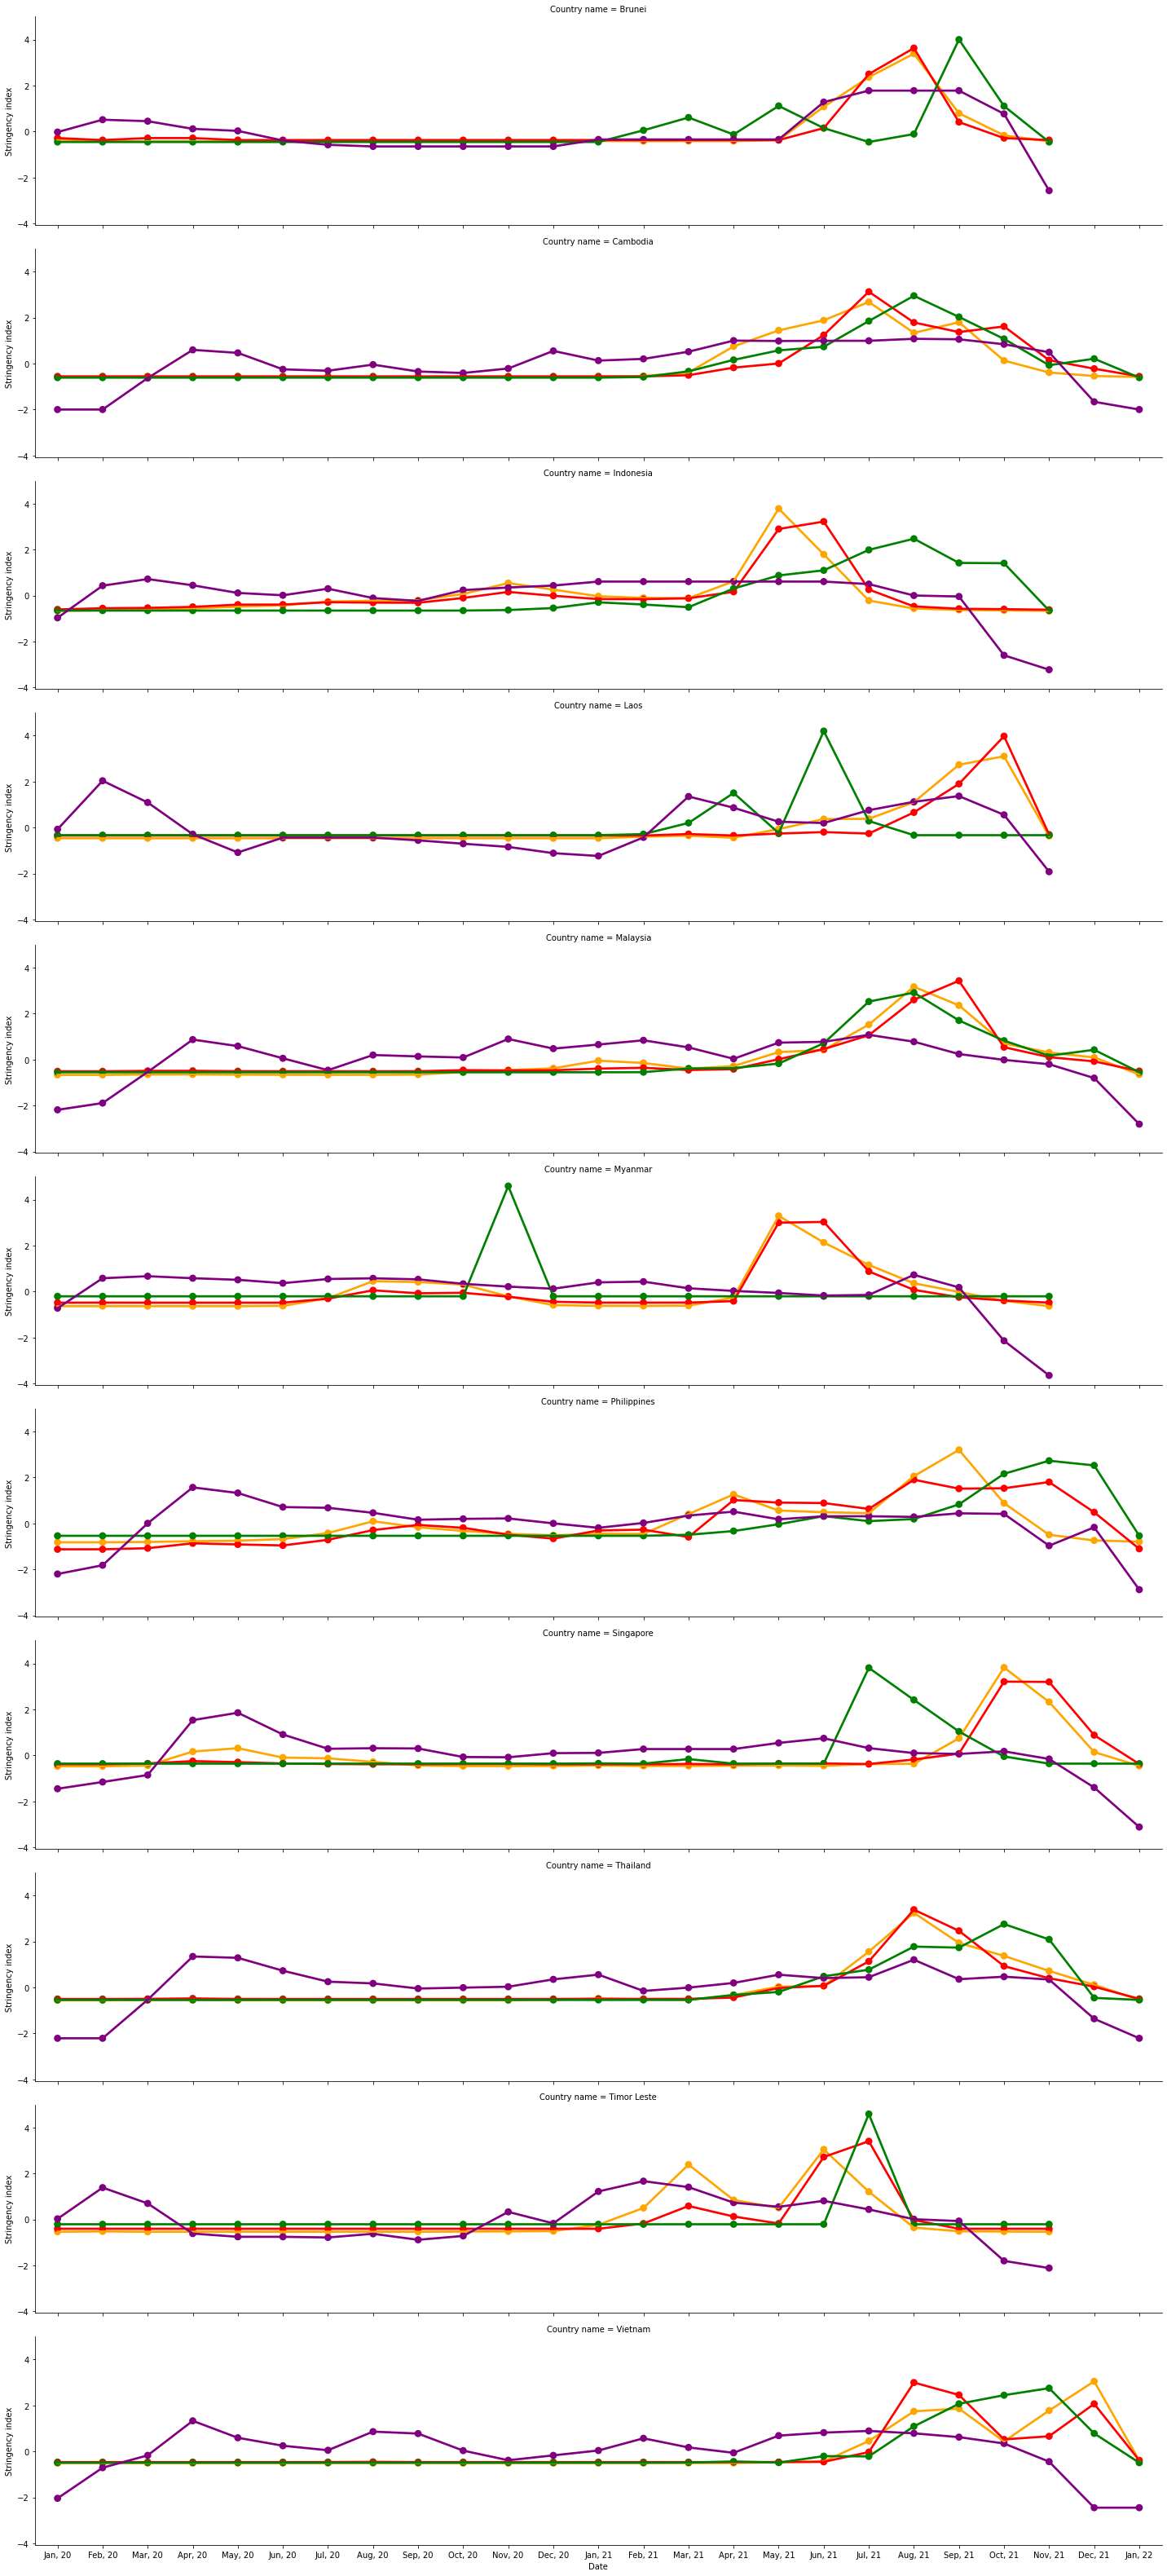

In [41]:
fig = sns.FacetGrid(df_covid_monthly_normalized, row='Country name', sharey=True, height=4, aspect=5, legend_out=True)
fig.map(sns.pointplot, "Date", "New cases", order=None, color='orange')
fig.map(sns.pointplot, "Date", "New deaths", order=None,color='red')
fig.map(sns.pointplot, "Date", "New vaccineinations", order=None,color='green')
fig.map(sns.pointplot, "Date", "Stringency index", order=None, color='purple')

In [42]:
df_covid_monthly

,Country name,Date,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index
0,Brunei,2020-03-01,129.0,129.0,1.0,1.0,0.0,0.0,46.619130
1,Brunei,2020-04-01,9.0,138.0,0.0,1.0,0.0,0.0,56.480000
2,Brunei,2020-05-01,3.0,141.0,1.0,2.0,0.0,0.0,55.286452
3,Brunei,2020-06-01,0.0,141.0,1.0,3.0,0.0,0.0,49.193667
4,Brunei,2020-07-01,0.0,141.0,0.0,3.0,0.0,0.0,47.576452
...,...,...,...,...,...,...,...,...,...
260,Vietnam,2021-09-01,328659.0,790755.0,8237.0,19301.0,22677776.0,42888157.0,72.134000
261,Vietnam,2021-10-01,130367.0,921122.0,2782.0,22083.0,25999970.0,81929875.0,65.634839
262,Vietnam,2021-11-01,316960.0,1238082.0,3169.0,25252.0,28697044.0,122083464.0,47.052667
263,Vietnam,2021-12-01,493175.0,1731257.0,7142.0,32394.0,11273507.0,148198862.0,0.000000


In [43]:
df_covid['Deaths/100 Cases'] = df_covid['Total deaths']*100/df_covid['Total cases']
df_covid

,Date,Country name,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index,Deaths/100 Cases
0,2020-03-09,Brunei,1.0,1.0,0.0,0.0,0.0,0.0,19.44,0.000000
1,2020-03-10,Brunei,0.0,1.0,0.0,0.0,0.0,0.0,19.44,0.000000
2,2020-03-11,Brunei,10.0,11.0,0.0,0.0,0.0,0.0,30.56,0.000000
3,2020-03-12,Brunei,0.0,11.0,0.0,0.0,0.0,0.0,30.56,0.000000
4,2020-03-13,Brunei,26.0,37.0,0.0,0.0,0.0,0.0,50.00,0.000000
...,...,...,...,...,...,...,...,...,...,...
7543,2021-12-28,Vietnam,14440.0,1680985.0,214.0,31632.0,0.0,148198862.0,0.00,1.881754
7544,2021-12-29,Vietnam,13889.0,1694874.0,245.0,31877.0,0.0,0.0,0.00,1.880789
7545,2021-12-30,Vietnam,19868.0,1714742.0,291.0,32168.0,0.0,0.0,0.00,1.875967
7546,2021-12-31,Vietnam,16515.0,1731257.0,226.0,32394.0,0.0,0.0,0.00,1.871126


In [44]:
fig_test = px.line(df_covid, x = 'Date', y = 'Deaths/100 Cases',title="Deaths/100 Cases", color='Country name')
fig_test.show()

In [45]:
df_covid

,Date,Country name,New cases,Total cases,New deaths,Total deaths,New vaccineinations,Total vaccineinations,Stringency index,Deaths/100 Cases
0,2020-03-09,Brunei,1.0,1.0,0.0,0.0,0.0,0.0,19.44,0.000000
1,2020-03-10,Brunei,0.0,1.0,0.0,0.0,0.0,0.0,19.44,0.000000
2,2020-03-11,Brunei,10.0,11.0,0.0,0.0,0.0,0.0,30.56,0.000000
3,2020-03-12,Brunei,0.0,11.0,0.0,0.0,0.0,0.0,30.56,0.000000
4,2020-03-13,Brunei,26.0,37.0,0.0,0.0,0.0,0.0,50.00,0.000000
...,...,...,...,...,...,...,...,...,...,...
7543,2021-12-28,Vietnam,14440.0,1680985.0,214.0,31632.0,0.0,148198862.0,0.00,1.881754
7544,2021-12-29,Vietnam,13889.0,1694874.0,245.0,31877.0,0.0,0.0,0.00,1.880789
7545,2021-12-30,Vietnam,19868.0,1714742.0,291.0,32168.0,0.0,0.0,0.00,1.875967
7546,2021-12-31,Vietnam,16515.0,1731257.0,226.0,32394.0,0.0,0.0,0.00,1.871126


### Growth Rate after 1000 Cases

In [46]:
# gt_100 = df_covid[df_covid['Total cases']>100]['Country name'].unique()
temp = df_covid.copy()

# temp = temp.groupby(['Country name', 'Date'])['Total cases'].sum().reset_index()
temp = temp[temp['Total cases']>1000]
temp

min_date = temp.groupby('Country name')['Date'].min().reset_index()
min_date.columns = ['Country name', 'Min Date']


from_100th_case = pd.merge(temp, min_date, on = 'Country name')
from_100th_case['N days'] = (from_100th_case['Date'] - from_100th_case['Min Date']).dt.days

fig = px.line(from_100th_case, x = 'N days', y = 'Total cases', color = 'Country name', title = 'N days from 1000 cases', height = 600)
fig.show()


### Growth Rate after 10000 Cases

In [47]:
# gt_10000 = df_covid[df_covid['Total cases']>100000]['Country name'].unique()
temp = df_covid.copy()

# temp = temp.groupby(['Country name', 'Date'])['Total cases'].sum().reset_index()
temp = temp[temp['Total cases']>10000]
temp

min_date = temp.groupby('Country name')['Date'].min().reset_index()
min_date.columns = ['Country name', 'Min Date']


from_10000th_case = pd.merge(temp, min_date, on = 'Country name')
from_10000th_case['N days'] = (from_10000th_case['Date'] - from_10000th_case['Min Date']).dt.days

fig = px.line(from_10000th_case, x = 'N days', y = 'Total cases', color = 'Country name', title = 'N days from 10000 cases', height = 600)
fig.show()


### Growth Rate after 100000 Cases

In [48]:
# gt_100000 = df_covid[df_covid['Total cases']>10000000]['Country name'].unique()
temp = df_covid.copy()

# temp = temp.groupby(['Country name', 'Date'])['Total cases'].sum().reset_index()
temp = temp[temp['Total cases']>100000]
temp

min_date = temp.groupby('Country name')['Date'].min().reset_index()
min_date.columns = ['Country name', 'Min Date']


from_100000th_case = pd.merge(temp, min_date, on = 'Country name')
from_100000th_case['N days'] = (from_100000th_case['Date'] - from_100000th_case['Min Date']).dt.days

fig = px.line(from_100000th_case, x = 'N days', y = 'Total cases', color = 'Country name', title = 'N days from 100000 cases', height = 600)
fig.show()


In [49]:
plotly.express.pie(df[df['Country name'] != 'Southeast Asia'], values='Total cases', names='Country name',
               title='Total cases', color_discrete_sequence=px.colors.sequential.RdBu)

In [50]:
plotly.express.pie(df[df['Country name'] != 'Southeast Asia'], values='Total deaths', names='Country name',
               title='Total cases', color_discrete_sequence=px.colors.sequential.RdBu)

In [51]:
correlation=df[~df['Country name'].isin(['Singapore', 'Brunei', 'Southeast Asia'])].corr(method='spearman')
correlation

,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature
Total cases,1.000000,0.950000,0.883333,0.733333,0.933333,0.583333,0.683333,0.376572
Total deaths,0.950000,1.000000,0.950000,0.716667,0.850000,0.600000,0.600000,0.259416
Population,0.883333,0.950000,1.000000,0.833333,0.816667,0.633333,0.433333,0.242680
Area,0.733333,0.716667,0.833333,1.000000,0.766667,0.633333,0.416667,-0.008368
GDP,0.933333,0.850000,0.816667,0.766667,1.000000,0.783333,0.516667,0.426782
Median age,0.583333,0.600000,0.633333,0.633333,0.783333,1.000000,0.116667,0.251048
Average rainfall,0.683333,0.600000,0.433333,0.416667,0.516667,0.116667,1.000000,0.092051
Average temperature,0.376572,0.259416,0.242680,-0.008368,0.426782,0.251048,0.092051,1.000000


<AxesSubplot:>

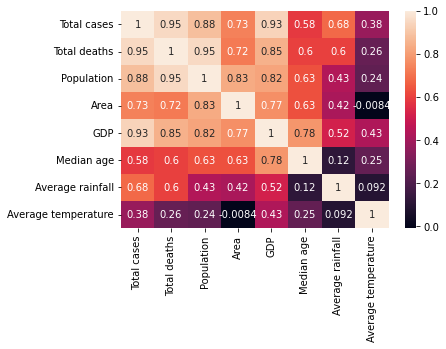

In [52]:
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)

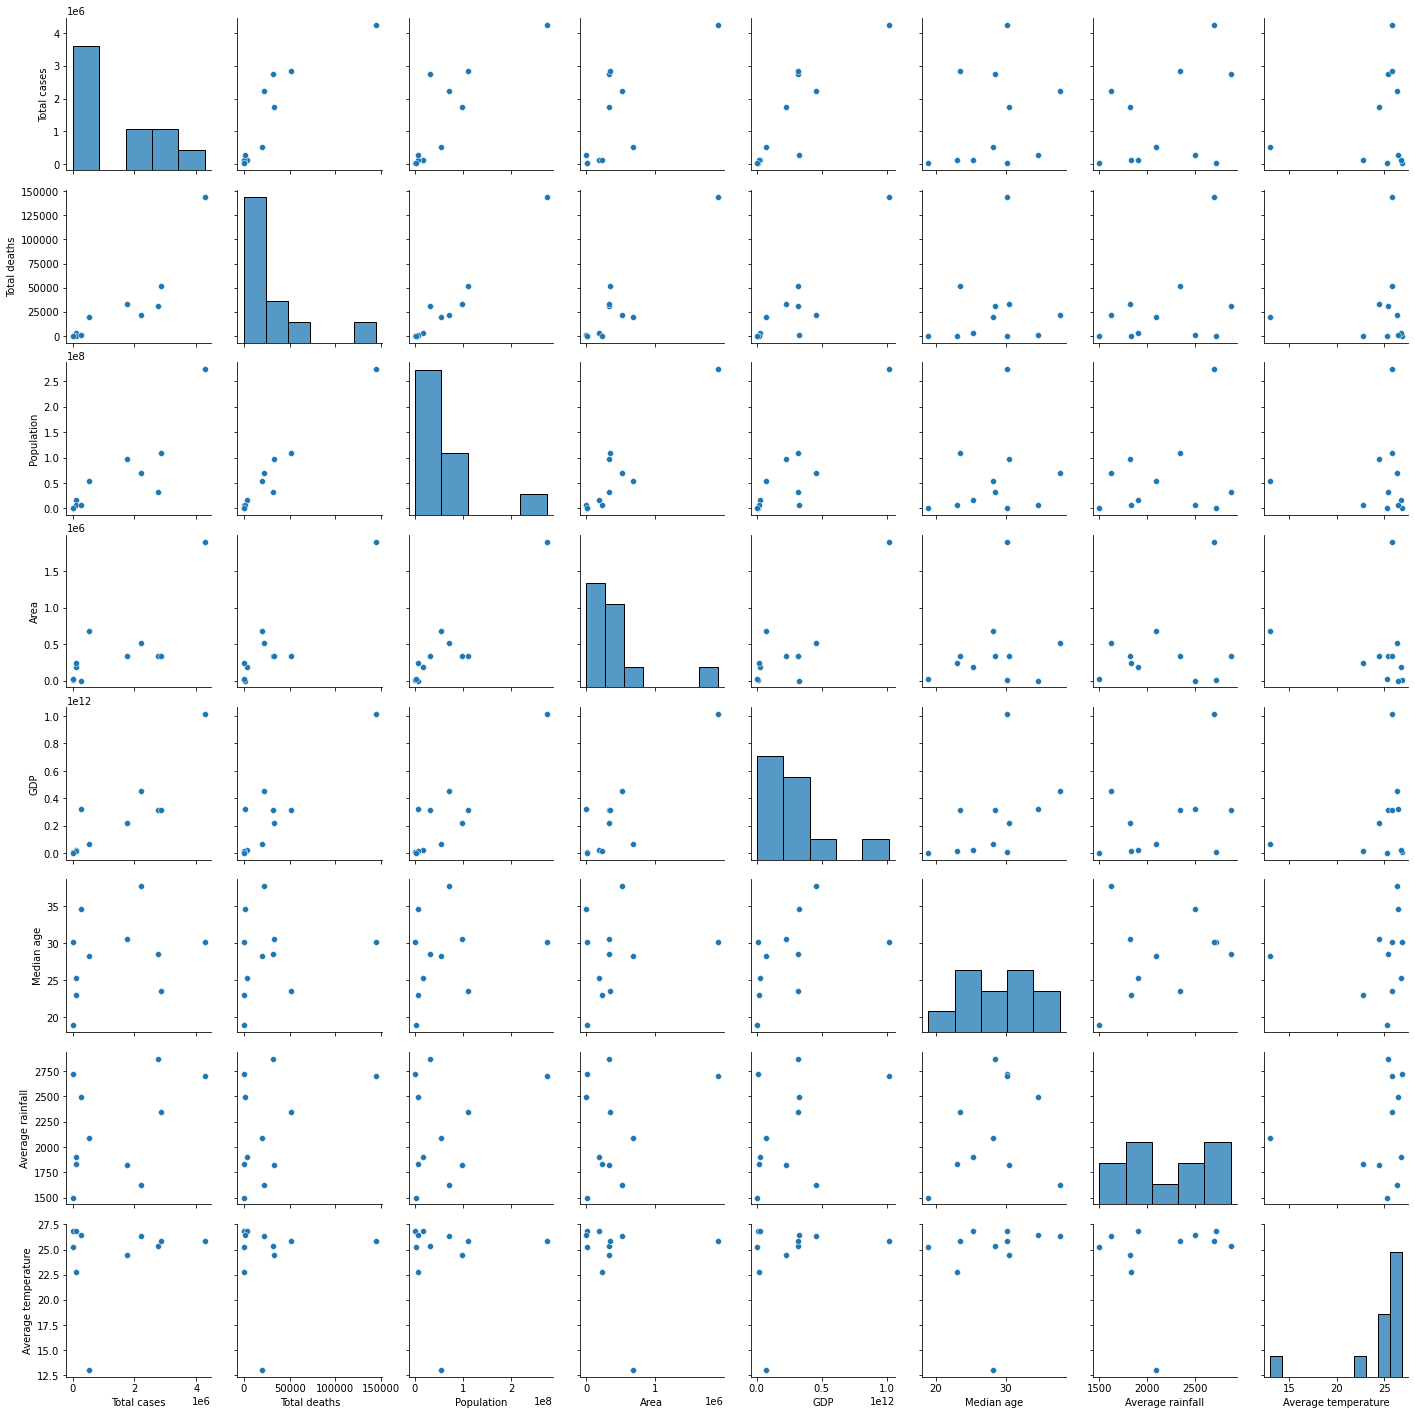

In [53]:
sns.pairplot(df[df['Country name'] != 'Southeast Asia'])

### Total cases and deaths vs Density

In [54]:
df['Density'] = df['Population']/df['Area']
df

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature,Density
0,Brunei,15470.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000,75.885343
1,Cambodia,120507.0,3012.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000,92.352114
2,Indonesia,4262994.0,144096.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000,143.614442
3,Laos,112083.0,374.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000,30.724493
4,Malaysia,2761472.0,31513.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000,97.840706
5,Myanmar,530946.0,19272.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000,80.419109
6,Philippines,2847486.0,51545.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000,320.082132
7,Singapore,279861.0,829.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000,8239.918310
8,Thailand,2226442.0,21708.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000,136.030515
9,Timor Leste,19839.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000,88.640917


In [55]:
def show_correlation(df, criteria, outliers):
    palette = sns.color_palette(cc.glasbey, n_colors=len(df['Country name'])-len(outliers))

    sns.relplot(x=criteria, y='Total cases', hue="Country name", size='Total cases',
            sizes=(40, 1000), alpha=.8, palette=palette,
            height=6, data=df[~df['Country name'].isin(outliers)])
    
    sns.relplot(x=criteria, y='Total deaths', hue="Country name", size='Total deaths',
            sizes=(40, 1000), alpha=.8, palette=palette,
            height=6, data=df[~df['Country name'].isin(outliers)])

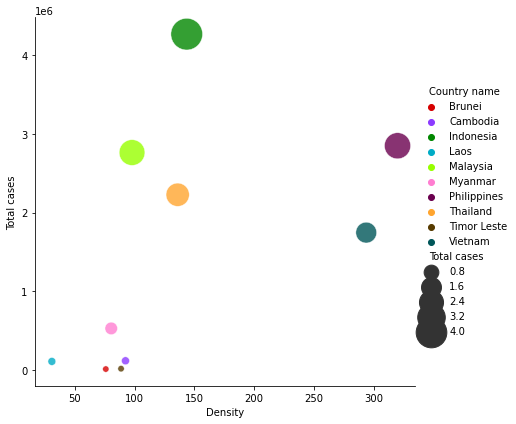

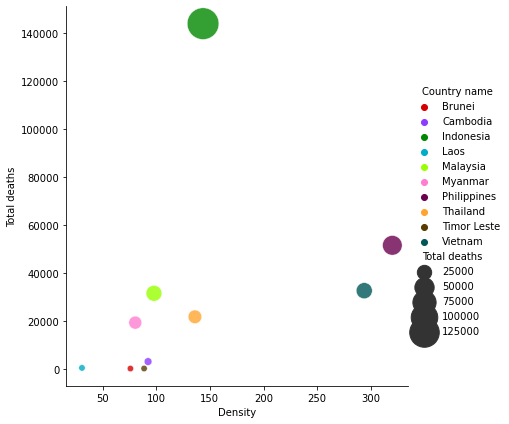

In [56]:
show_correlation(df, 'Density', ['Singapore', 'Southeast Asia'])

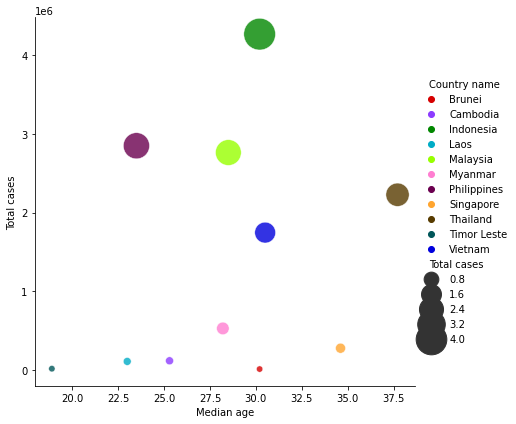

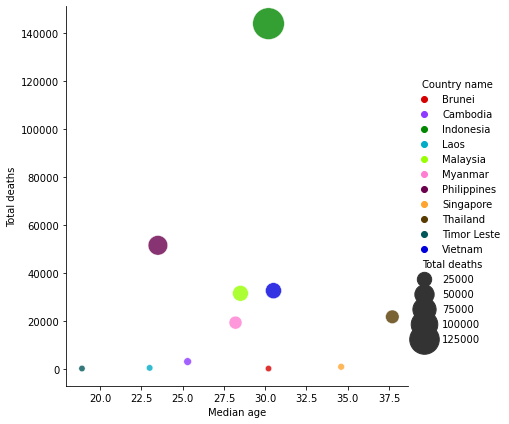

In [57]:
show_correlation(df, 'Median age', ['Southeast Asia'])

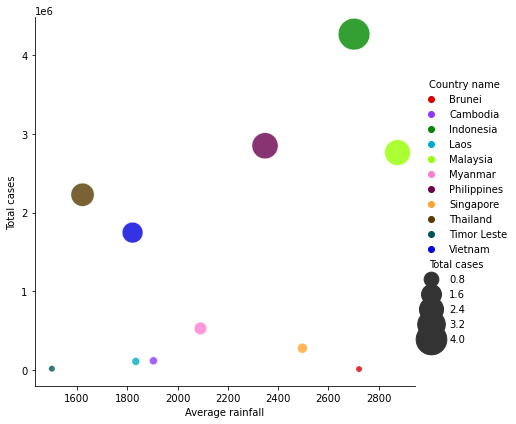

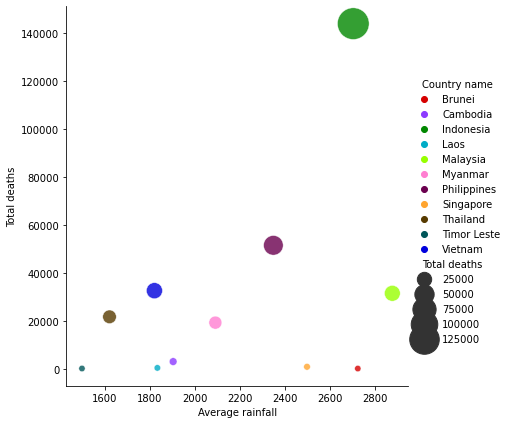

In [58]:
show_correlation(df, 'Average rainfall', ['Southeast Asia'])

### Total cases and deaths vs GDP per capita

In [59]:
temp=df.copy()
temp['GDP per capita'] = df['GDP']/df['Population']
temp

,Country name,Total cases,Total deaths,Population,Area,GDP,Median age,Average rainfall,Average temperature,Density,GDP per capita
0,Brunei,15470.0,98.0,437479,5765,1.212809e+10,30.200000,2722.000000,26.850000,75.885343,27722.676979
1,Cambodia,120507.0,3012.0,16718965,181035,2.215821e+10,25.300000,1904.000000,26.800000,92.352114,1325.333805
2,Indonesia,4262994.0,144096.0,273523615,1904569,1.015421e+12,30.200000,2702.000000,25.850000,143.614442,3712.368993
3,Laos,112083.0,374.0,7275560,236800,1.685309e+10,23.000000,1834.000000,22.800000,30.724493,2316.397292
4,Malaysia,2761472.0,31513.0,32365999,330803,3.147103e+11,28.500000,2875.000000,25.400000,97.840706,9723.483570
5,Myanmar,530946.0,19272.0,54409800,676578,6.706875e+10,28.200000,2091.000000,13.050000,80.419109,1232.659292
6,Philippines,2847486.0,51545.0,109581078,342353,3.135952e+11,23.500000,2348.000000,25.850000,320.082132,2861.764225
7,Singapore,279861.0,829.0,5850342,710,3.239072e+11,34.600000,2497.000000,26.450000,8239.918310,55365.521266
8,Thailand,2226442.0,21708.0,69799978,513120,4.553027e+11,37.700000,1622.000000,26.300000,136.030515,6522.963130
9,Timor Leste,19839.0,122.0,1318445,14874,2.954621e+09,18.900000,1500.000000,25.250000,88.640917,2240.989196


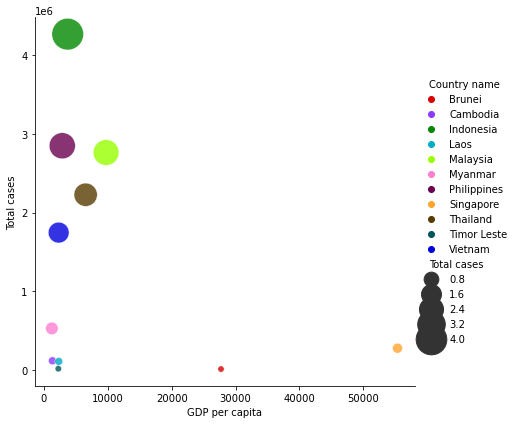

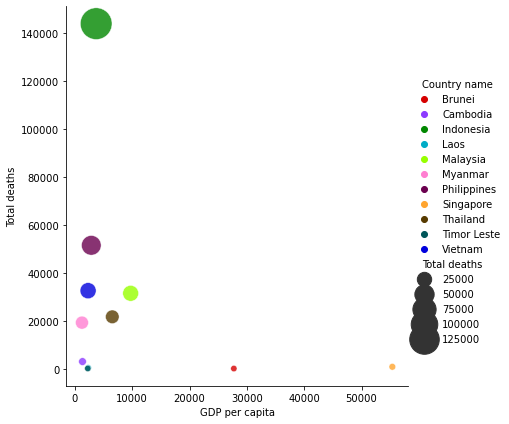

In [60]:
show_correlation(temp, 'GDP per capita', ['Southeast Asia'])

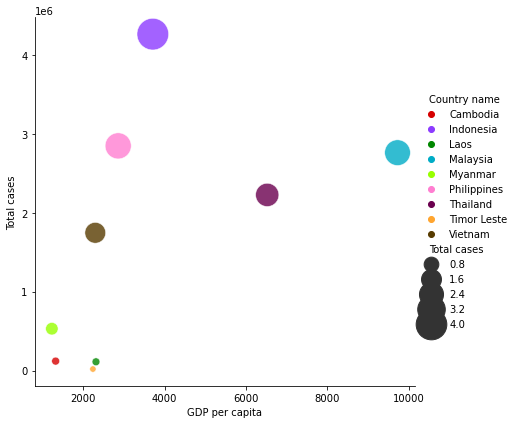

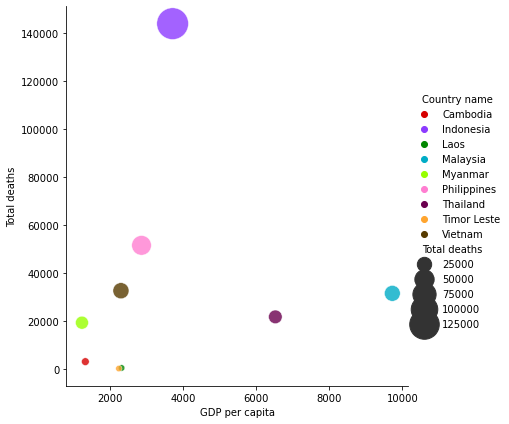

In [61]:
show_correlation(temp, 'GDP per capita', ['Singapore', 'Brunei', 'Southeast Asia'])